In [163]:
import numpy as np
import matplotlib.pyplot as plt

from poisson_solver import poisson_solve
from zero_form import ZeroForm
from one_form import OneForm

In [164]:
L = 1.0
N = 2 ** 7
h = (L / N)

# Create the array of vertices, xyz indexing.
V_ind = np.asarray([[[[i,j,k] for k in range(N)] for j in range(N)] for i in range(N)])
V = V_ind * h
V.shape

(128, 128, 128, 3)

In [165]:
def curve_function(t: float):
    return np.array([0.5, 0.5, 0]) + 0.25 * np.array([np.cos(2 * np.pi * t), (3 / 2) *np.sin(2 * np.pi * t), 0])

t_range = np.linspace(0, 1, 16)
curve_data = np.array([curve_function(t) for t in t_range])
curve_data

array([[0.75      , 0.5       , 0.        ],
       [0.72838636, 0.65252624, 0.        ],
       [0.66728265, 0.77867931, 0.        ],
       [0.57725425, 0.85664619, 0.        ],
       [0.47386788, 0.87294571, 0.        ],
       [0.375     , 0.82475953, 0.        ],
       [0.29774575, 0.72041947, 0.        ],
       [0.2554631 , 0.57796688, 0.        ],
       [0.2554631 , 0.42203312, 0.        ],
       [0.29774575, 0.27958053, 0.        ],
       [0.375     , 0.17524047, 0.        ],
       [0.47386788, 0.12705429, 0.        ],
       [0.57725425, 0.14335381, 0.        ],
       [0.66728265, 0.22132069, 0.        ],
       [0.72838636, 0.34747376, 0.        ],
       [0.75      , 0.5       , 0.        ]])

In [166]:
def SignedIntersection(Γ, f):
    """
    Compute the flux-weighted signed intersection of a discrete curve segment with a finite rectangular grid face,
    ensuring that the final sum is properly normalized.

    Parameters:
    Γ (list of tuples): List of curve points [(x1, y1, z1), (x2, y2, z2), ...].
    f (tuple): (v, e_i, size) where:
        - v (tuple): Base vertex defining the face (x, y, z).
        - e_i (int): Normal direction index (0=x,1=y,2=z).
        - size (tuple): Size of the face in the two perpendicular directions.

    Returns:
    (tuple) containing
    float: Net flux-weighted signed intersection value, constrained to [-1,1].
    int: The number of crossings
    """
    v, e_i, size = f  # Extract face properties
    normal_axis = e_i  # The axis normal to the face
    
    # Define the normal vector of the face
    face_normal = np.zeros(3)
    face_normal[normal_axis] = 1  # Example: If normal is in the Z direction, it's (0,0,1)
    
    # Get the two axes defining the plane of the face
    other_axes = [0, 1, 2]
    other_axes.remove(normal_axis)  # Get the two remaining coordinate axes
    j, k = other_axes  # These define the face’s 2D plane
    
    # Compute face boundaries based on size
    face_min = np.array([v[j], v[k]])  # Min corner in (j,k) plane
    face_max = face_min + np.array(size)  # Max corner in (j,k) plane
    
    total_flux = 0.0  # Accumulate weighted signed contributions
    crossing_count = 0  # Track number of valid crossings

    for segment_index in range(len(Γ) - 1):
        p1 = np.array(Γ[segment_index])
        p2 = np.array(Γ[segment_index + 1])

        # Extract coordinate values along the normal direction
        coord1, coord2 = p1[normal_axis], p2[normal_axis]
        face_coord = v[normal_axis]  # The face coordinate in this direction

        # Check if the segment crosses the plane of the face
        if (coord1 < face_coord and coord2 > face_coord) or (coord1 > face_coord and coord2 < face_coord):
            
            # Compute intersection point
            t = (face_coord - coord1) / (coord2 - coord1)  # Linear interpolation factor
            intersection = p1 + t * (p2 - p1)  # Compute actual intersection point
            
            # Extract intersection in face's coordinate system
            intersection_2d = np.array([intersection[j], intersection[k]])

            # Check if the intersection lies within the finite face
            if np.all(face_min <= intersection_2d) and np.all(intersection_2d <= face_max):
                
                # Compute curve tangent at intersection
                curve_tangent = (p2 - p1) / np.linalg.norm(p2 - p1)  # Normalize segment vector

                # Compute projection of tangent onto face normal
                flux_contribution = np.dot(curve_tangent, face_normal)
                
                total_flux += flux_contribution  # Accumulate contribution
                crossing_count += 1  # Count the number of crossings
    
    # Ensure final result is within [-1,1]
    return (total_flux, crossing_count)


In [167]:
# Test Case: Multiple crossings with different angles
Γ_test = [
    (0.5, 0.5, -0.5),  # Before first intersection
    (0.5, 0.5, 0.5),   # Perpendicular through the face (should contribute fully)
    (0.5, 1.0, 0.5),
    (0.5, 0.25, 0.5),
]

# Face at vertex (0,0,0) with normal along Z-axis (e_i = 2), size (1.0 x 1.0) in X and Y
f_test = ((0, 0, 0), 2, (1.0, 1.0))

# Run the test
flux_result = SignedIntersection(Γ_test, f_test)
flux_result

(np.float64(1.0), 1)

In [168]:
# Compute delta_Gamma form as a discrete array
delta_gamma = np.zeros_like(V).astype(float)
num_crossings = np.zeros_like(V_ind)
Nx, Ny, Nz, _ = V_ind.shape
for x in range(Nx):
    for y in range(Ny):
        for z in range(Nz):
            for i in range(3):
                face = (V[x, y, z], i, (h, h))
                flux, n_crossings = SignedIntersection(curve_data, face)
                delta_gamma[x, y, z, i] = flux
                num_crossings[x, y, z, i] = n_crossings


## Visualization of intersection data

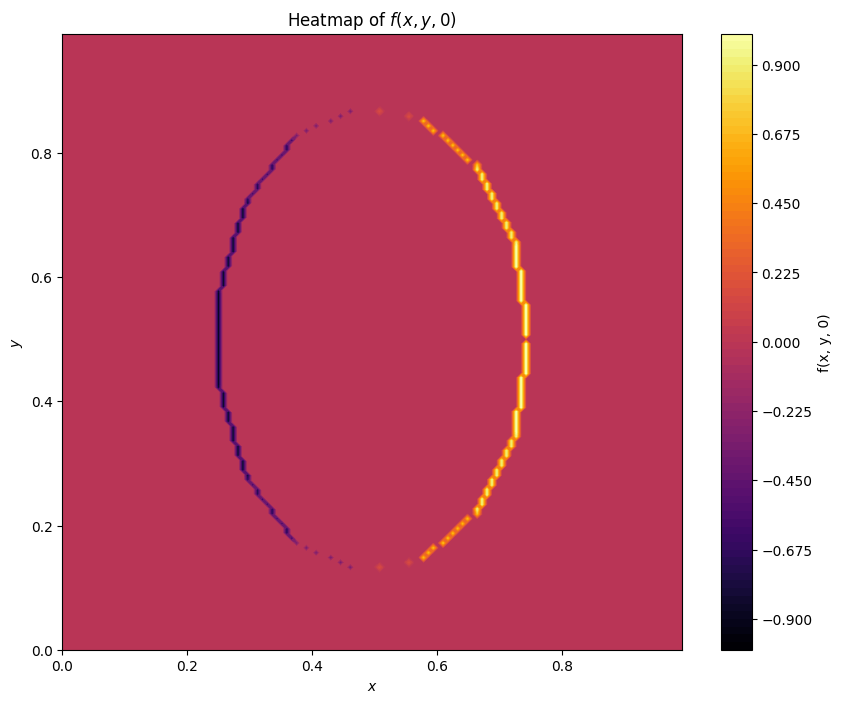

In [169]:
fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(V[:, :, 0, 0], V[:, :, 0, 1], delta_gamma[:, :, 0, 1], levels=80, cmap='inferno')
plt.colorbar(label='f(x, y, 0)')
plt.title('Heatmap of $f(x, y, 0)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

Solve the poisson problems related to Biot-Savart field problem.

In [170]:
Psi_0 = poisson_solve(ZeroForm(V_ind, scalar_field=delta_gamma[..., 0]))
Psi_1 = poisson_solve(ZeroForm(V_ind, scalar_field=delta_gamma[..., 1]))
Psi_2 = poisson_solve(ZeroForm(V_ind, scalar_field=delta_gamma[..., 2]))

Psi = np.asarray([Psi_0, Psi_1, Psi_2])
Psi.shape

(3, 128, 128, 128)

## Visualize Psi vector fields

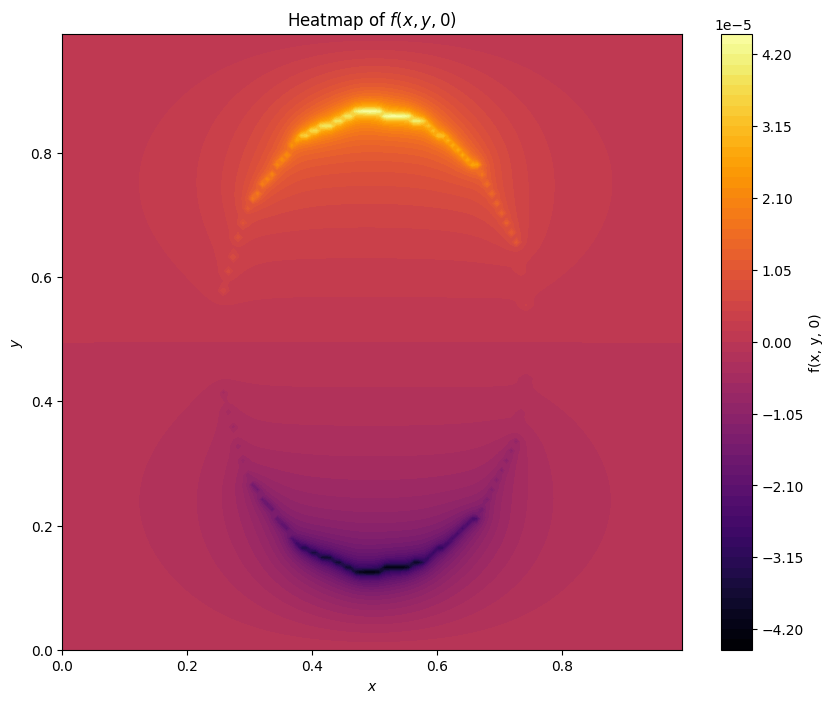

In [171]:
fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(V[:, :, 0, 0], V[:, :, 0, 1], Psi_0[:, :, 0], levels=80, cmap='inferno')
plt.colorbar(label='f(x, y, 0)')
plt.title('Heatmap of $f(x, y, 0)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

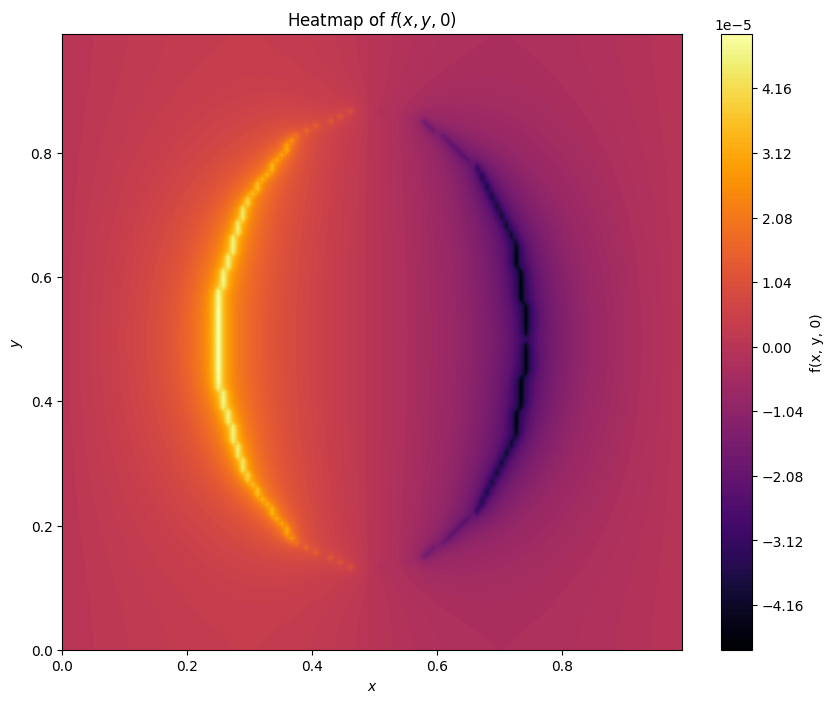

In [172]:
fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(V[:, :, 0, 0], V[:, :, 0, 1], Psi_1[:, :, 0], levels=128, cmap='inferno')
plt.colorbar(label='f(x, y, 0)')
plt.title('Heatmap of $f(x, y, 0)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()


# Calculation of $\tilde{\eta}_0$

In [173]:
def levi_civita_symbol(i, j, k):
    denominator = abs(j - i) * abs(k - i) * abs(k - j)
    numerator = (j - i) * (k - i) * (k - j)

    if denominator == 0:
        return 0
    return numerator / denominator

# Brute force calculation for combinations which have \epsilon_{i, j, k} = 1
total_permutations = []
for i in range(3):
    permutations = []
    for j in range(3):
        for k in range(3):
            if levi_civita_symbol(i, j, k) == 1:
                permutations.append([j, k])
    total_permutations.append(permutations)
total_permutations = [el[0] for el in total_permutations]
total_permutations

[[1, 2], [2, 0], [0, 1]]

In [174]:

Nx, Ny, Nz, _ = V_ind.shape
for x in range(Nx):
    for y in range(Ny):
        for z in range(Nz):
            for i in range(3):
                j, k = total_permutations[i]
                